In [1]:
# Load the necessary packages
# create spark and sparkcontext objects
import numpy as np
import time
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.ml import feature, regression, Pipeline, evaluation
from pyspark.sql import functions as fn, Row
from pyspark import sql
from pyspark.sql import types as t
from pyspark.mllib.stat import Statistics
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql.functions import isnull, when, count, col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import GBTRegressor

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

Data Source: https://www.kaggle.com/ravi72munde/uber-lyft-cab-prices

In [2]:
# import weather data
weather_df = spark.read.option("header", "true").csv("weather.csv")

In [3]:
weather_df.printSchema()

root
 |-- temp: string (nullable = true)
 |-- location: string (nullable = true)
 |-- clouds: string (nullable = true)
 |-- pressure: string (nullable = true)
 |-- rain: string (nullable = true)
 |-- time_stamp: string (nullable = true)
 |-- humidity: string (nullable = true)
 |-- wind: string (nullable = true)



In [4]:
# type casting all columns of weather dataframe
weather_df = weather_df.withColumn("temp", weather_df.temp.cast('float'))
weather_df = weather_df.withColumn("clouds", weather_df.clouds.cast('float'))
weather_df = weather_df.withColumn("pressure", weather_df.pressure.cast('float'))
weather_df = weather_df.withColumn("rain", weather_df.rain.cast('float'))
weather_df = weather_df.withColumn("humidity", weather_df.humidity.cast('float'))
weather_df = weather_df.withColumn("wind", weather_df.wind.cast('float'))
weather_df = weather_df.withColumn("time_stamp_w", fn.from_unixtime(weather_df.time_stamp.cast('bigint'), 'yyyy-MM-dd HH:mm:ss'))
weather_df = weather_df.drop("time_stamp")


In [5]:
# import cab data
cab_df = spark.read.option("header", "true").csv("cab_rides.csv")

In [6]:
cab_df.printSchema()

root
 |-- distance: string (nullable = true)
 |-- cab_type: string (nullable = true)
 |-- time_stamp: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- source: string (nullable = true)
 |-- price: string (nullable = true)
 |-- surge_multiplier: string (nullable = true)
 |-- id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- name: string (nullable = true)



In [7]:
# type casting all columns of cab dataframe
cab_df = cab_df.withColumn("distance", cab_df.distance.cast('float'))
cab_df = cab_df.withColumn("price", cab_df.price.cast('float'))
cab_df = cab_df.withColumn("surge_multiplier", cab_df.surge_multiplier.cast('float'))
cab_df = cab_df.withColumn("time_stamp", fn.from_unixtime((cab_df.time_stamp.cast('bigint')/1000), 'yyyy-MM-dd HH:mm:ss'))

**Splitting of the time stamp column into Date, Hours, Minutes, Seconds**

In [8]:
split_col = fn.split(weather_df['time_stamp_w'], ' ')
weather_df = weather_df.withColumn('Date_w', split_col.getItem(0))
weather_df = weather_df.withColumn('Time_w', split_col.getItem(1))

In [9]:
time_split_col = fn.split(weather_df['Time_w'],':')
weather_df = weather_df.withColumn('Hour_w', time_split_col.getItem(0))
weather_df = weather_df.withColumn('Minutes_w', time_split_col.getItem(1))
weather_df = weather_df.withColumn('Seconds_w', time_split_col.getItem(2))

In [10]:
split_col = fn.split(cab_df['time_stamp'], ' ')
cab_df = cab_df.withColumn('Date', split_col.getItem(0))
cab_df = cab_df.withColumn('Time', split_col.getItem(1))

In [11]:
time_split_col = fn.split(cab_df['Time'],':')
cab_df = cab_df.withColumn('Hour', time_split_col.getItem(0))
cab_df = cab_df.withColumn('Minutes', time_split_col.getItem(1))
cab_df = cab_df.withColumn('Seconds', time_split_col.getItem(2))

**Merging the cab and weather data based on source, Date and Hour**

In [12]:
cab_df = cab_df.withColumn('merged_key', 
                    fn.concat(fn.col('source'),fn.lit('-'), fn.col('Date'),fn.lit('-'), fn.col('Hour')))

In [13]:
weather_df = weather_df.withColumn('merged_key', 
                    fn.concat(fn.col('location'),fn.lit('-'), fn.col('Date_w'),fn.lit('-'),fn.col('Hour_w')))

In [14]:
weather_df = weather_df.\
    groupBy('merged_key').\
    agg(fn.avg('temp').alias('temp'), fn.avg('clouds').alias('clouds'), fn.avg('pressure').alias('pressure'), fn.avg('rain').alias('rain'), fn.avg('humidity').alias('humidity'), fn.avg('wind').alias('wind'))

In [15]:
merged_df = cab_df.join(weather_df, on='merged_key')

In [16]:
# final merged dataframe
merged_df.count()

690107

**Dropping Unwanted Columns**

In [17]:
merged_df = merged_df.drop('Minutes_w')
merged_df = merged_df.drop('Seconds_w')
merged_df = merged_df.drop('Minutes')
merged_df = merged_df.drop('Seconds')

**Checking for Null Values**

In [18]:
from pyspark.sql.functions import isnull, when, count, col

merged_df.select([count(when(isnull(c), c)).alias(c) for c in merged_df.columns]).show()

+----------+--------+--------+----------+-----------+------+-----+----------------+---+----------+----+----+----+----+----+------+--------+------+--------+----+
|merged_key|distance|cab_type|time_stamp|destination|source|price|surge_multiplier| id|product_id|name|Date|Time|Hour|temp|clouds|pressure|  rain|humidity|wind|
+----------+--------+--------+----------+-----------+------+-----+----------------+---+----------+----+----+----+----+----+------+--------+------+--------+----+
|         0|       0|       0|         0|          0|     0|54865|               0|  0|         0|   0|   0|   0|   0|   0|     0|       0|571430|       0|   0|
+----------+--------+--------+----------+-----------+------+-----+----------------+---+----------+----+----+----+----+----+------+--------+------+--------+----+



In [19]:
merged_df.select("price","name").where(fn.col('name')=='Taxi').count()

54865

**Removing rows with Taxi as cab name since thwy have price (dependent) value as 0**

In [20]:
merged_df = merged_df.select(fn.col("*")).filter(fn.col('name')!='Taxi')

**Replacing Null values of rain column with '0' indicating 0 inches of rain**

In [21]:
merged_df = merged_df.fillna(0,subset=['rain'])

In [22]:
merged_df = merged_df.withColumn("Hour", merged_df.Hour.cast('string'))
merged_df = merged_df.withColumn("Hour_w", merged_df.Hour.cast('string'))
merged_df = merged_df.withColumn("Date",merged_df['Date'].cast(t.DateType()))
merged_df = merged_df.withColumn('DayOfTheWeek', fn.date_format('Date', 'u'))
merged_df = merged_df.withColumn("DayOfTheWeek", merged_df.DayOfTheWeek.cast('string'))
merged_df = merged_df.withColumn("temp", merged_df.temp.cast('float'))
merged_df = merged_df.withColumn("clouds", merged_df.clouds.cast('float'))
merged_df = merged_df.withColumn("pressure", merged_df.pressure.cast('float'))
merged_df = merged_df.withColumn("rain", merged_df.rain.cast('float'))
merged_df = merged_df.withColumn("humidity", merged_df.humidity.cast('float'))
merged_df = merged_df.withColumn("wind", merged_df.wind.cast('float'))
merged_df=merged_df.drop('Hour_w')
merged_df=merged_df.drop('Date_w')

In [23]:
training_df, validation_df, testing_df = merged_df.randomSplit([0.6, 0.3, 0.1], seed=0)

**Evaluator: Root Mean Square Error**

In [24]:
evaluator = evaluation.RegressionEvaluator(labelCol='price', metricName='rmse')

**Codifying the data**

**Classic Linear Regression**

In [73]:
classic_lr = Pipeline(stages=[feature.VectorAssembler(inputCols=['distance','surge_multiplier','temp','clouds','pressure','rain','humidity','wind'],
                                                     outputCol='features'), regression.LinearRegression(labelCol='price', featuresCol='features')]).fit(training_df)

In [74]:
classic_rmse = evaluator.evaluate(classic_lr.transform(validation_df))
classic_rmse

8.468606619844305

**Linear Regression with all the features - cab + weather**

In [76]:
pipe_feat = Pipeline(stages=[StringIndexer(inputCol='name', outputCol="name_index",stringOrderType='alphabetAsc'),
                             StringIndexer(inputCol='DayOfTheWeek', outputCol="DayOfTheWeek_index",stringOrderType='alphabetAsc'),
                             StringIndexer(inputCol='Hour', outputCol="Hour_index",stringOrderType='alphabetAsc'),
                             StringIndexer(inputCol='cab_type', outputCol="cab_type_index",stringOrderType='alphabetAsc'),
                             StringIndexer(inputCol='destination', outputCol="destination_index",stringOrderType='alphabetAsc'),
                             OneHotEncoder(inputCol="name_index", outputCol="name_feat", dropLast=False),
                             OneHotEncoder(inputCol="DayOfTheWeek_index", outputCol="DayOfTheWeek_feat", dropLast=False),
                             OneHotEncoder(inputCol="Hour_index", outputCol="Hour_feat", dropLast=False),
                             OneHotEncoder(inputCol="cab_type_index", outputCol="cab_feat", dropLast=False),
                             OneHotEncoder(inputCol="destination_index", outputCol="destination_feat", dropLast=False),
                             feature.VectorAssembler(inputCols=['distance','surge_multiplier','temp','clouds','pressure','rain','humidity','wind'],
                                                     outputCol='numerical_features'),
                             feature.StandardScaler(inputCol='numerical_features',outputCol='scaled_numerical_features'),
                             feature.VectorAssembler(inputCols=["scaled_numerical_features","name_feat","DayOfTheWeek_feat","Hour_feat","cab_feat","destination_feat"],
                                                     outputCol='final_features')])

In [77]:
lr_1 = Pipeline(stages=[pipe_feat, regression.LinearRegression(labelCol='price', featuresCol='final_features')]).fit(training_df)

In [78]:
lr_1_rmse = evaluator.evaluate(lr_1.transform(validation_df))

In [79]:
lr_1_rmse

2.503849801978462

**Elastic net regularization with all the features - cab + weather**

In [32]:
lr = regression.LinearRegression(labelCol='price', featuresCol='final_features',regParam=0.01,elasticNetParam=0.2)

In [33]:
lr_2 = Pipeline(stages=[pipe_feat, lr]).fit(training_df)

In [34]:
regularized_rmse = evaluator.evaluate(lr_2.transform(validation_df))
regularized_rmse

2.5037402078448725

In [35]:
# weights of every variable for feature importance
lr_2.stages[-1].coefficients

DenseVector([3.1655, 1.7561, 0.0, -0.0023, 0.0, 0.0, -0.0076, 0.0112, 4.8521, 14.6073, 0.8792, 6.1595, 15.4117, -7.3212, -1.6028, -10.1764, -6.8872, -5.8844, -0.0027, -5.8815, 0.0122, 0.0, 0.0, -0.0026, 0.0043, 0.0377, -0.0, 0.0, 0.0, 0.0215, -0.0153, 0.0, 0.0, 0.0, 0.0, -0.0017, 0.0, 0.0, 0.0365, 0.0413, -0.0126, -0.0111, -0.0229, 0.0, 0.0517, -0.0299, -0.0066, 0.0126, 0.0188, -0.0042, 0.0, 0.2853, -0.2853, -0.0375, -0.3181, 0.0504, -0.2856, 0.4062, 0.1005, -0.0301, 0.1648, 0.0207, -0.1008, 0.1795, -0.0869])

**Grid Search: Regularization Parameters**

In [36]:
lambda_par = 0.02
alpha_par = 0.3
reg_lr = regression.LinearRegression().\
        setLabelCol('price').\
        setFeaturesCol('final_features').\
        setRegParam(lambda_par).\
        setMaxIter(100).\
        setElasticNetParam(alpha_par)

In [37]:
lr_3 = Pipeline(stages=[pipe_feat, reg_lr])

In [38]:
grid = ParamGridBuilder().\
    addGrid(reg_lr.regParam, [0.1, 0.01, 0.001]).\
    addGrid(reg_lr.elasticNetParam, [0.1, 0.2, 0.4]).\
    build()

In [39]:
grid

[{Param(parent='LinearRegression_02dbe1766820', name='regParam', doc='regularization parameter (>= 0).'): 0.1,
  Param(parent='LinearRegression_02dbe1766820', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.1},
 {Param(parent='LinearRegression_02dbe1766820', name='regParam', doc='regularization parameter (>= 0).'): 0.1,
  Param(parent='LinearRegression_02dbe1766820', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.2},
 {Param(parent='LinearRegression_02dbe1766820', name='regParam', doc='regularization parameter (>= 0).'): 0.1,
  Param(parent='LinearRegression_02dbe1766820', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.4},
 {Param(parent='

In [40]:
all_models = []
for j in range(len(grid)):
    print("Fitting model {}".format(j+1))
    model = lr_3.fit(training_df, grid[j])
    all_models.append(model)

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9


In [41]:
model1_rmse = evaluator.evaluate(all_models[0].transform(validation_df))

In [42]:
model1_rmse

2.5060325930402683

In [43]:
all_models[0].stages[-1].coefficients

DenseVector([3.1252, 1.7377, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.7692, 14.4466, 1.3927, 6.6302, 15.8152, -6.6823, -1.0094, -9.5216, -6.8254, -5.8303, 0.0, -5.8277, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0179, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0213, -0.2961, 0.046, -0.2409, 0.3831, 0.0362, -0.0294, 0.1308, 0.0026, -0.1018, 0.135, -0.0697])

In [44]:
grid[0]

{Param(parent='LinearRegression_02dbe1766820', name='regParam', doc='regularization parameter (>= 0).'): 0.1,
 Param(parent='LinearRegression_02dbe1766820', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.1}

In [45]:
model2_rmse = evaluator.evaluate(all_models[1].transform(validation_df))
model2_rmse

2.507651569579436

In [46]:
model3_rmse = evaluator.evaluate(all_models[2].transform(validation_df))
model3_rmse

2.51239044609687

In [47]:
model4_rmse = evaluator.evaluate(all_models[3].transform(validation_df))
model4_rmse

2.5037837331412436

In [48]:
model5_rmse = evaluator.evaluate(all_models[4].transform(validation_df))
model5_rmse

2.5037402078448725

In [49]:
model6_rmse = evaluator.evaluate(all_models[5].transform(validation_df))
model6_rmse

2.503764443021414

In [50]:
model7_rmse = evaluator.evaluate(all_models[6].transform(validation_df))
model7_rmse

2.5038378295922987

In [51]:
model8_rmse = evaluator.evaluate(all_models[7].transform(validation_df))
model8_rmse

2.503829544239254

In [52]:
model9_rmse = evaluator.evaluate(all_models[8].transform(validation_df))
model9_rmse

2.5038182508343136

In [53]:
# obtain the best parameters for elastic net regularization 
all_models[2].stages[-1].coefficients

DenseVector([3.1076, 1.7148, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.7956, 14.5017, 1.4145, 6.6658, 15.8787, -6.4822, -0.7933, -9.3396, -6.6391, -5.6413, 0.0, -5.6382, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.1919, 0.0, -0.1262, 0.2982, 0.0, 0.0, 0.0382, 0.0, -0.0065, 0.0386, 0.0])

** **Note: elasticNetParam corresponds to α and regParam corresponds to λ**

**Feature Selection using Elastic net Regularization with best parameters on entire dataset**

In [27]:
best_model_LR = Pipeline(stages=[pipe_feat, regression.LinearRegression(labelCol='price', featuresCol='final_features',regParam=0.1,elasticNetParam=0.2)]).fit(merged_df)

In [29]:
feature_reg = best_model_LR.stages[0].stages[-3].getInputCols()
for i in range(5):
    for j in range(len(best_model_LR.stages[0].stages[i].labels)):
        col = best_model_LR.stages[0].stages[i].getInputCol() + "_" + best_model_LR.stages[0].stages[i].labels[j]
        #col = col.replace(" ", "_")
        feature_reg.append(col)

In [30]:
# Creating a dataframe of features with their importances
coeff_pd = pd.DataFrame(list(zip(feature_reg, best_model_LR.stages[-1].coefficients.toArray())),
            columns = ['features', 'weights']).sort_values('weights', ascending = False)

In [31]:
coeff_pd.count()

features    65
weights     65
dtype: int64

In [32]:
coeff_pd

,features,weights
12,name_Lux Black XL,15.802992
9,name_Black SUV,14.438882
11,name_Lux Black,6.614424
8,name_Black,4.750990
0,distance,3.125276
1,surge_multiplier,1.719672
10,name_Lux,1.364799
57,destination_Financial District,0.338748
63,destination_Theatre District,0.094743
60,destination_North Station,0.090324


**Feature Importance of weather on price**

In [59]:
weather_list = ['temp', 'clouds', 'humidity', 'wind', 'pressure', 'rain']
weather_imp = coeff_pd[coeff_pd['features'].isin(weather_list)]

In [60]:
weather_imp

,features,weights
7,wind,0.0
5,rain,0.0
4,pressure,0.0
3,clouds,0.0
2,temp,0.0
6,humidity,0.0


**Random Forest**

**Feature Importance  
Random Forest with OneHotEncoding (All Features): Fit on entire data**

In [36]:
pipe_all_rf = Pipeline(stages=[feature.StringIndexer(inputCol='name', outputCol="name_index", stringOrderType='alphabetAsc'),
                               feature.StringIndexer(inputCol='DayOfTheWeek', outputCol="DayOfTheWeek_index", stringOrderType='alphabetAsc'),
                               feature.StringIndexer(inputCol='Hour', outputCol="Hour_index", stringOrderType='alphabetAsc'),
                               feature.StringIndexer(inputCol='destination', outputCol="destination_index", stringOrderType='alphabetAsc'),
                               feature.StringIndexer(inputCol='cab_type', outputCol="cab_type_index", stringOrderType='alphabetAsc'),
                               feature.OneHotEncoder(inputCol="name_index", outputCol="name_feat", dropLast=False),
                               feature.OneHotEncoder(inputCol="DayOfTheWeek_index", outputCol="DayOfTheWeek_feat", dropLast=False),
                               feature.OneHotEncoder(inputCol="Hour_index", outputCol="Hour_feat", dropLast=False),
                               feature.OneHotEncoder(inputCol="destination_index", outputCol="destination_feat", dropLast=False),
                               feature.OneHotEncoder(inputCol = 'cab_type_index', outputCol = 'cab_type_feat', dropLast=False),
                               feature.VectorAssembler(inputCols=['distance','surge_multiplier','temp','clouds','pressure','rain','humidity','wind'],
                                                     outputCol='numerical_features'),
                               feature.StandardScaler(inputCol='numerical_features',outputCol='scaled_numerical_features'),
                               feature.VectorAssembler(inputCols=['scaled_numerical_features', 'name_feat', 'DayOfTheWeek_feat', 'Hour_feat', 'destination_feat', 'cab_type_feat'],
                                                     outputCol='final_features')])

In [37]:
rf = regression.RandomForestRegressor(labelCol='price', featuresCol="final_features", maxDepth = 7, numTrees = 600)

In [38]:
pipe_rf5 = Pipeline(stages=[pipe_all_rf, rf]).fit(merged_df)

In [39]:
features_all = pipe_rf5.stages[0].stages[-3].getInputCols()
for i in range(5):
    for j in range(len(pipe_rf5.stages[0].stages[i].labels)):
        col = pipe_rf5.stages[0].stages[i].getInputCol() + "_" + pipe_rf5.stages[0].stages[i].labels[j]
        #col = col.replace(" ", "_")
        features_all.append(col)

In [40]:
feature_rf = pd.DataFrame(list(zip(features_all, pipe_rf5.stages[-1].featureImportances.toArray())),
            columns = ['features', 'importance']).sort_values('importance', ascending = False)

In [41]:
feature_rf

,features,importance
12,name_Lux Black XL,0.298925
9,name_Black SUV,0.245763
0,distance,0.101268
15,name_Shared,0.087586
11,name_Lux Black,0.063191
8,name_Black,0.037390
16,name_UberPool,0.033198
1,surge_multiplier,0.032950
13,name_Lyft,0.022261
17,name_UberX,0.019978


**Random Forest with Selected Features**

In [81]:
new_model = Pipeline(stages=[feature.StringIndexer(inputCol='name', outputCol="name_index",stringOrderType='alphabetAsc'),
                             feature.StringIndexer(inputCol='cab_type', outputCol="cab_type_index",stringOrderType='alphabetAsc'),
                             feature.StringIndexer(inputCol='destination', outputCol="destination_index",stringOrderType='alphabetAsc'),
                             feature.VectorAssembler(inputCols=['distance','surge_multiplier', 'name_index', 'cab_type_index', 'destination_index'], 
                                                     outputCol='final_features')])

**Random Forest without encoding**

In [82]:
# after several combinations of parameters, this model turns out to have the lowest RMSE value. 
# Thus this our best random forest model
pipe_rf = Pipeline(stages=[new_model, rf]).fit(training_df)

In [83]:
pipe_rf.stages

[PipelineModel_e29b2c551aec,
 RandomForestRegressionModel (uid=RandomForestRegressor_16d9177e8f8d) with 600 trees]

In [84]:
RMSE = evaluator.evaluate(pipe_rf.transform(validation_df))
print("RMSE of Model = ", RMSE)

RMSE of Model =  2.0808460464452687


In [67]:
# Creating a dataframe of features with their importances
pd.DataFrame(list(zip(pipe_rf.stages[0].stages[-1].getInputCols(), pipe_rf.stages[-1].featureImportances.toArray())),
            columns = ['features', 'importance']).sort_values('importance', ascending = False)

,features,importance
2,name_index,0.810109
0,distance,0.121035
1,surge_multiplier,0.053201
4,destination_index,0.012991
3,cab_type_index,0.002665


**Random Forest with OneHotEncoding**

In [ ]:
new_model3 = Pipeline(stages=[feature.StringIndexer(inputCol='name', outputCol="name_index",stringOrderType='alphabetAsc'),
                             feature.StringIndexer(inputCol='cab_type', outputCol="cab_type_index",stringOrderType='alphabetAsc'),
                             feature.StringIndexer(inputCol='destination', outputCol="destination_index",stringOrderType='alphabetAsc'),
                              feature.OneHotEncoder(inputCol = 'name_index', outputCol = 'name_feat'),
                              feature.OneHotEncoder(inputCol = 'cab_type_index', outputCol = 'cab_type_feat'),
                            feature.OneHotEncoder(inputCol = 'destination_index', outputCol = 'destination_feat'),
                             feature.VectorAssembler(inputCols=['distance','surge_multiplier', 'name_feat', 'cab_type_feat', 'destination_feat'], 
                                                     outputCol='final_features')])

In [ ]:
pipe_rf3 = Pipeline(stages=[new_model3, rf]).fit(training_df)

In [ ]:
RMSE3 = evaluator.evaluate(pipe_rf3.transform(validation_df))
print("RMSE of Model = ", RMSE3)

**Gradient Boosting with Selected Features**

**Gradient Boosting without Encoding**

In [ ]:
gb1 = Pipeline(stages=[new_model,GBTRegressor(featuresCol="final_features", maxDepth = 7, maxIter=10,labelCol="price")]).fit(training_df)

In [ ]:
gb_rmse1 = evaluator.evaluate(gb1.transform(validation_df))
gb_rmse1

In [ ]:
gb2 = Pipeline(stages=[new_model,GBTRegressor(featuresCol="final_features", maxDepth = 7, maxIter=20,labelCol="price")]).fit(training_df)

In [ ]:
gb_rmse2 = evaluator.evaluate(gb2.transform(validation_df))
gb_rmse2

In [62]:
gb3 = Pipeline(stages=[new_model,GBTRegressor(featuresCol="final_features", maxDepth = 7, maxIter=30,labelCol="price")]).fit(training_df)

In [63]:
gb_rmse3 = evaluator.evaluate(gb3.transform(validation_df))
gb_rmse3

1.7279872617092797

In [32]:
pred_df = gb3.transform(testing_df)

**Gradient Boosting With Encoding**

In [ ]:
gb_e1 = Pipeline(stages=[new_model3,GBTRegressor(featuresCol="final_features", maxDepth = 7, maxIter=10,labelCol="price")]).fit(training_df)

In [ ]:
gb_e1_rmse = evaluator.evaluate(gb_e1.transform(validation_df))
gb_e1_rmse

In [ ]:
gb_e2 = Pipeline(stages=[new_model3,GBTRegressor(featuresCol="final_features", maxDepth = 7, maxIter=20,labelCol="price")]).fit(training_df)

In [ ]:
gb_e2_rmse = evaluator.evaluate(gb_e2.transform(validation_df))
gb_e2_rmse

In [ ]:
gb_e3 = Pipeline(stages=[new_model3,GBTRegressor(featuresCol="final_features", maxDepth = 7, maxIter=30,labelCol="price")]).fit(training_df)

In [ ]:
gb_e3_rmse = evaluator.evaluate(gb_e3.transform(validation_df))
gb_e3_rmse

In [ ]:
pred_df = gb_e3.transform(testing_df)

**Best Model**

In [64]:
# Gradient Bossting without encoded attributes and with parameters maxDepth = 7 and maxIter=30 is the best model
best_model = gb3

**Binning Data: To check if Hour, DayOfTheWeek, weather have improved influenc on price after feature engineering**

In [ ]:
features_df = merged_df

**Hour & DayOfTheWeek**

In [58]:
features_df = features_df.withColumn("Hour", features_df.Hour.cast('integer'))
features_df = features_df.withColumn("DayOfTheWeek", features_df.DayOfTheWeek.cast('integer'))

In [59]:
features_df.select("Hour").summary().show()

+-------+-----------------+
|summary|             Hour|
+-------+-----------------+
|  count|           635242|
|   mean|11.63644878644674|
| stddev| 6.94576477457282|
|    min|                0|
|    25%|                6|
|    50%|               12|
|    75%|               18|
|    max|               23|
+-------+-----------------+



In [60]:
features_df = feature.QuantileDiscretizer(numBuckets=6, inputCol = 'Hour', outputCol = 'Hour_bin').fit(features_df).transform(features_df)

In [61]:
features_df = features_df.withColumn("Hour_bin", features_df.Hour_bin.cast('string'))

In [62]:
features_df.select('Hour', 'Hour_bin').distinct().orderBy('Hour').show(24)

+----+--------+
|Hour|Hour_bin|
+----+--------+
|   0|     0.0|
|   1|     0.0|
|   2|     0.0|
|   3|     1.0|
|   4|     1.0|
|   5|     1.0|
|   6|     1.0|
|   7|     1.0|
|   8|     2.0|
|   9|     2.0|
|  10|     2.0|
|  11|     2.0|
|  12|     3.0|
|  13|     3.0|
|  14|     3.0|
|  15|     3.0|
|  16|     4.0|
|  17|     4.0|
|  18|     4.0|
|  19|     4.0|
|  20|     5.0|
|  21|     5.0|
|  22|     5.0|
|  23|     5.0|
+----+--------+



In [63]:
features_df = features_df.withColumn("TypeOfDay", fn.when(fn.col("DayOfTheWeek") > 5, 1).otherwise(0))

In [64]:
features_df = features_df.withColumn("TypeOfDay", features_df.TypeOfDay.cast('string'))

In [65]:
features_df.select('DayOfTheWeek', 'TypeOfDay').distinct().orderBy('DayOfTheWeek').show()

+------------+---------+
|DayOfTheWeek|TypeOfDay|
+------------+---------+
|           1|        0|
|           2|        0|
|           3|        0|
|           4|        0|
|           5|        0|
|           6|        1|
|           7|        1|
+------------+---------+



In [66]:
features_df = features_df.withColumn("Hour", features_df.Hour.cast('string'))
features_df = features_df.withColumn("DayOfTheWeek", features_df.DayOfTheWeek.cast('string'))

In [26]:
training_df2, validation_df2, testing_df2 = features_df.randomSplit([0.6, 0.3, 0.1], seed=0)

**Random Forest (Without Encoding, with Hour_bin, TypeOfDay)**

In [ ]:
new_model10 = Pipeline(stages=[feature.StringIndexer(inputCol='name', outputCol="name_index", stringOrderType='alphabetAsc'),
                               feature.StringIndexer(inputCol='TypeOfDay', outputCol="TypeOfDay_index", stringOrderType='alphabetAsc'),
                               feature.StringIndexer(inputCol='Hour_bin', outputCol="Hour_bin_index", stringOrderType='alphabetAsc'),
                               feature.StringIndexer(inputCol='destination', outputCol="destination_index", stringOrderType='alphabetAsc'),
                               feature.StringIndexer(inputCol='cab_type', outputCol="cab_type_index", stringOrderType='alphabetAsc'),
                               feature.OneHotEncoder(inputCol="name_index", outputCol="name_feat", dropLast=False),
                               feature.OneHotEncoder(inputCol="TypeOfDay_index", outputCol="TypeOfDay_feat", dropLast=False),
                               feature.OneHotEncoder(inputCol="Hour_bin_index", outputCol="Hour_bin_feat", dropLast=False),
                               feature.OneHotEncoder(inputCol="destination_index", outputCol="destination_feat", dropLast=False),
                               feature.OneHotEncoder(inputCol = 'cab_type_index', outputCol = 'cab_type_feat'),
                               feature.VectorAssembler(inputCols=['distance','surge_multiplier','temp','clouds','pressure','rain','humidity','wind'],
                                                     outputCol='numerical_features'),
                               feature.StandardScaler(inputCol='numerical_features',outputCol='scaled_numerical_features'),
                               feature.VectorAssembler(inputCols=['scaled_numerical_features', 'name_feat', 'TypeOfDay_feat', 'Hour_bin_feat', 'destination_feat', 'cab_type_feat'],
                                                     outputCol='final_features')])

In [ ]:
pipe_rf10 = Pipeline(stages=[new_model10, rf]).fit(training_df2)

In [ ]:
RMSE10 = evaluator.evaluate(pipe_rf10.transform(validation_df2))
print("RMSE of Model = ", RMSE10)

In [ ]:
features10 = pipe_rf10.stages[0].stages[-3].getInputCols()
for i in range(5):
    for j in range(len(pipe_rf10.stages[0].stages[i].labels)):
        col = pipe_rf10.stages[0].stages[i].getInputCol() + "_" + pipe_rf10.stages[0].stages[i].labels[j]
        #col = col.replace(" ", "_")
        features10.append(col)

In [ ]:
pd.DataFrame(list(zip(features10, pipe_rf10.stages[-1].featureImportances.toArray())),
            columns = ['features', 'importance']).sort_values('importance', ascending = False)

**Weather**

In [ ]:
# using QuantileDiscretizer for bucketing weather attributes to create evenly distributed buckets
features_df = feature.QuantileDiscretizer(numBuckets=4, inputCol = 'temp', outputCol = 'temp_bin').fit(features_df).transform(features_df)
features_df = feature.QuantileDiscretizer(numBuckets=4, inputCol = 'clouds', outputCol = 'clouds_bin').fit(features_df).transform(features_df)
features_df = feature.QuantileDiscretizer(numBuckets=4, inputCol = 'humidity', outputCol = 'humidity_bin').fit(features_df).transform(features_df)
features_df = feature.QuantileDiscretizer(numBuckets=4, inputCol = 'wind', outputCol = 'wind_bin').fit(features_df).transform(features_df)
features_df = feature.QuantileDiscretizer(numBuckets=2, inputCol = 'rain', outputCol = 'rain_bin').fit(features_df).transform(features_df)
features_df = feature.QuantileDiscretizer(numBuckets=4, inputCol = 'pressure', outputCol = 'pressure_bin').fit(features_df).transform(features_df)

In [ ]:
# type casting of quantile discretized attributes for string indexing
features_df = features_df.withColumn("temp_bin", features_df.Hour.cast('string'))
features_df = features_df.withColumn("clouds_bin", features_df.Hour.cast('string'))
features_df = features_df.withColumn("humidity_bin", features_df.Hour.cast('string'))
features_df = features_df.withColumn("wind_bin", features_df.Hour.cast('string'))
features_df = features_df.withColumn("rain_bin", features_df.Hour.cast('string'))
features_df = features_df.withColumn("pressure_bin", features_df.Hour.cast('string'))

In [ ]:
training_df2, validation_df2, testing_df2 = features_df.randomSplit([0.6, 0.3, 0.1], seed=0)

**Random Forest (With Encoding, with weather bins)**

In [ ]:
new_model11 = Pipeline(stages=[feature.StringIndexer(inputCol='name', outputCol="name_index",stringOrderType='alphabetAsc'),
                             feature.StringIndexer(inputCol='cab_type', outputCol="cab_type_index",stringOrderType='alphabetAsc'),
                             feature.StringIndexer(inputCol='destination', outputCol="destination_index",stringOrderType='alphabetAsc'),
                             feature.StringIndexer(inputCol='temp_bin', outputCol="temp_bin_index",stringOrderType='alphabetAsc'),
                             feature.StringIndexer(inputCol='clouds_bin', outputCol="clouds_bin_index",stringOrderType='alphabetAsc'),
                             feature.StringIndexer(inputCol='humidity_bin', outputCol="humidity_bin_index",stringOrderType='alphabetAsc'),
                             feature.StringIndexer(inputCol='wind_bin', outputCol="wind_bin_index",stringOrderType='alphabetAsc'),
                             feature.StringIndexer(inputCol='rain_bin', outputCol="rain_bin_index",stringOrderType='alphabetAsc'),
                             feature.StringIndexer(inputCol='pressure_bin', outputCol="pressure_bin_index",stringOrderType='alphabetAsc'),
                             feature.VectorAssembler(inputCols=['distance','surge_multiplier', 'name_index', 'cab_type_index', 'destination_index', 'temp_bin_index', 'clouds_bin_index', 'pressure_bin_index', 
                                                               'humidity_bin_index', 'wind_bin_index', 'rain_bin_index'], 
                                                     outputCol='final_features')])

In [ ]:
rf = regression.RandomForestRegressor(labelCol='price', featuresCol='final_features', maxDepth = 7, numTrees = 600)

In [ ]:
pipe_rf11 = Pipeline(stages=[new_model11, rf]).fit(training_df2)

In [ ]:
RMSE11 = evaluator.evaluate(pipe_rf11.transform(validation_df2))
print("RMSE of Model = ", RMSE11)

In [ ]:
# importance of feature engineered weather data on price
features11 = pipe_rf11.stages[0].stages[-1].getInputCols()
pd.DataFrame(list(zip(features11, pipe_rf11.stages[-1].featureImportances.toArray())),
            columns = ['features', 'importance']).sort_values('importance', ascending = False)

**Uber & Lyft model performance comparison**

In [28]:
# creating dataframe with only cab type Uber
uber_df = merged_df.filter(fn.col('cab_type') == 'Uber')

In [29]:
uber_df.count()

329140

In [30]:
# creating dataframe with only cab type Lyft
lyft_df = merged_df.filter(fn.col('cab_type') == 'Lyft')

In [31]:
lyft_df.count()

306102

In [32]:
# creating training, testing and validation dataframe for Uber dataframe
training_uber_df, validation_uber_df, testing_uber_df = uber_df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [33]:
# creating training, testing and validation dataframe for Lyft dataframe
training_lyft_df, validation_lyft_df, testing_lyft_df = lyft_df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [36]:
# gradient boosting model with best parameters for Uber dataframe 
gb_uber = Pipeline(stages=[new_model,GBTRegressor(featuresCol="final_features", maxDepth = 7, maxIter=30,labelCol="price")]).fit(training_uber_df)

In [37]:
# performance of best model on only Uber Data
gb_uber_rmse = evaluator.evaluate(gb_uber.transform(validation_uber_df))
gb_uber_rmse

1.9207187480592922

In [38]:
# gradient boosting model with best parameters for Lyft dataframe
gb_lyft = Pipeline(stages=[new_model,GBTRegressor(featuresCol="final_features", maxDepth = 7, maxIter=30,labelCol="price")]).fit(training_lyft_df)

In [39]:
# performance of best model on only Lyft Data
gb_lyft_rmse = evaluator.evaluate(gb_lyft.transform(validation_lyft_df))
gb_lyft_rmse

1.4626069056242934

**Comparison between General, Uber, Lyft Performance**

In [42]:
plot_rmse = [gb_rmse3, gb_uber_rmse, gb_lyft_rmse]

In [65]:
plot_rmse = pd.DataFrame(list(zip(['General', 'Uber', 'Lyft'], [gb_rmse3, gb_uber_rmse, gb_lyft_rmse])), columns = ['Model', 'RMSE'])

In [66]:
plot_rmse.Model

0    General
1       Uber
2       Lyft
Name: Model, dtype: object

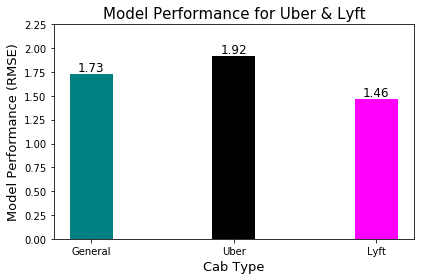

In [200]:
plt.bar(plot_rmse.Model, plot_rmse.RMSE, width = 0.3, color = ['teal', 'black', 'fuchsia'])
plt.xlabel('Cab Type', fontsize = 13)
plt.ylabel('Model Performance (RMSE)', fontsize = 13)
plt.title('Model Performance for Uber & Lyft', fontsize = 15)
x_coord = [0, 1, 2]
for i in range(len(plot_rmse.RMSE)):
    plt.text(x = x_coord[i], y = plot_rmse.RMSE[i], s = round(plot_rmse.RMSE[i], 2), horizontalalignment='center', verticalalignment='bottom', fontsize = 12)
plt.tight_layout()
plt.ylim(0, 2.25)
plt.savefig('Model Performance for Uber & Lyft')

**Feature Importance Graph**

Using signs from feature importance of elastic net regularization model to indicate the direction in which the features affect the price. 
At the same time using feature importance values from the best random forest model.

In [52]:
features_sign = pd.DataFrame(list(zip(feature_reg, best_model_LR.stages[-1].coefficients.toArray())),
            columns = ['features', 'weights']).sort_values('weights', ascending = False)

In [53]:
features_sign.loc[features_sign.weights < 0, "sign"] = -1
features_sign.loc[features_sign.weights >= 0, "sign"] = 1
features_sign

,features,weights,sign
12,name_Lux Black XL,15.802992,1.0
9,name_Black SUV,14.438882,1.0
11,name_Lux Black,6.614424,1.0
8,name_Black,4.750990,1.0
0,distance,3.125276,1.0
1,surge_multiplier,1.719672,1.0
10,name_Lux,1.364799,1.0
57,destination_Financial District,0.338748,1.0
63,destination_Theatre District,0.094743,1.0
60,destination_North Station,0.090324,1.0


In [54]:
feature_importance = pd.DataFrame(list(zip(features_all, pipe_rf5.stages[-1].featureImportances.toArray())),
            columns = ['features', 'importance']).sort_values('importance', ascending = False)

In [55]:
feature_importance = feature_importance.merge(features_sign, on='features')

In [56]:
feature_importance["feature_imp"] = feature_importance.importance * feature_importance.sign
feature_importance = feature_importance.iloc[:18,]

In [57]:
feature_importance.set_index("features", inplace = True)
feature_importance.sort_values("feature_imp", inplace = True)
feature_importance

,importance,weights,sign,feature_imp
features,,,,
name_Shared,0.087586,-9.483870,-1.0,-0.087586
name_UberPool,0.033198,-6.798085,-1.0,-0.033198
name_Lyft,0.022261,-6.611573,-1.0,-0.022261
name_UberX,0.019978,-5.792427,-1.0,-0.019978
name_WAV,0.017339,-5.793463,-1.0,-0.017339
name_Lyft XL,0.002316,-0.958700,-1.0,-0.002316
destination_Boston University,0.001259,0.006915,1.0,0.001259
destination_Financial District,0.002076,0.338748,1.0,0.002076
name_UberXL,0.003799,0.000000,1.0,0.003799


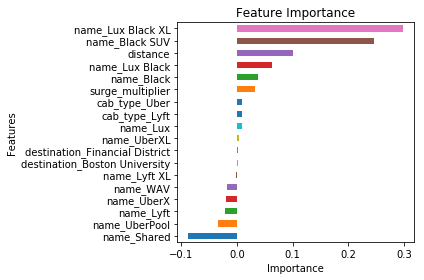

In [58]:
feature_importance['feature_imp'].plot(kind = 'barh', title = 'Feature Importance')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.savefig('FI_1', dpi = 400)

**Testing One Line Prediction for best model - gradient boosting**

In [65]:
testing_df = spark.createDataFrame([(4.5, 1, 'Uber', 'UberPool', 'Financial District','3','21',40.3,9.81,1,991.93,0,0.67)], ['distance', 'surge_multiplier', 'cab_type', 'name', 'destination','DayOfTheWeek','Hour','temp','wind','clouds','pressure','rain','humidity'])
predict_test = best_model.transform(testing_df)
predict_test.select(fn.round("prediction", 2).alias('Predicted Price')).show()

+---------------+
|Predicted Price|
+---------------+
|          10.79|
+---------------+



In [66]:
testing_df = spark.createDataFrame([(5, 1, 'Lyft', 'Lux Black XL', 'Boston University')], ['distance', 'surge_multiplier', 'cab_type', 'name', 'destination'])
predict_test = best_model.transform(testing_df)
predict_test.select(fn.round("prediction", 2).alias('Predicted Price')).show()

+---------------+
|Predicted Price|
+---------------+
|          45.81|
+---------------+



In [67]:
price_df = merged_df.select('price').toPandas()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


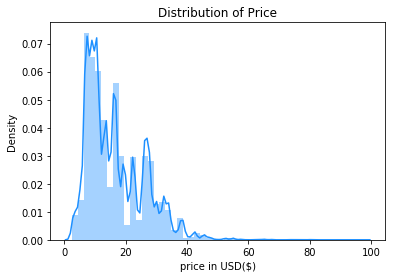

In [68]:
sns.distplot(price_df.price , color="dodgerblue")
plt.xlabel("price in USD($)")
plt.ylabel("Density")
plt.title("Distribution of Price") 
plt.savefig("Densityplot",dpi=300)

Density plot on the poster for Price Column

In [85]:
plot_rmse1 = [classic_rmse, lr_1_rmse, regularized_rmse, RMSE, gb_rmse3]

In [86]:
plot_rmse1 = pd.DataFrame(list(zip(['Classic Linear Regression', 'Linear Regression', 'Regularized Regression','Random Forest','Gradient Boosting'], [classic_rmse, lr_1_rmse, regularized_rmse, RMSE, gb_rmse3])), columns = ['Model', 'RMSE'])

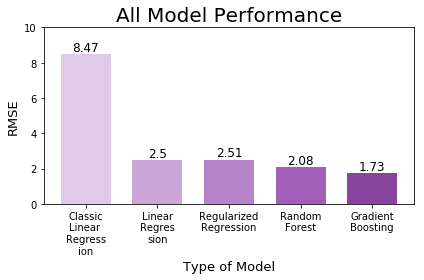

In [87]:
from textwrap import wrap

labels = plot_rmse1.Model
labels = ['\n'.join(wrap(l,l.find(" "))) for l in labels]

bar1 = plt.bar(labels, plot_rmse1.RMSE, width = 0.7, color = ['#e0cae8', '#cba6d8', '#b683c9', '#a25fba', '#8845a0'])
plt.xlabel('Type of Model', fontsize = 13)
plt.ylabel('RMSE', fontsize = 13)
plt.title('', fontsize = 15)

x_coord = [0, 1, 2, 3, 4]
for i in range(len(plot_rmse1.RMSE)):
    plt.text(x = x_coord[i], y = plot_rmse1.RMSE[i], s = round(plot_rmse1.RMSE[i], 2), horizontalalignment='center', verticalalignment='bottom', fontsize = 12)

plt.ylim(0,10)
plt.title('All Model Performance', fontsize = 20)
# plt.xticks(label=labels, rotation=0)
plt.tight_layout()
plt.savefig('All Model Performance', dpi=300)